In [12]:
!pip install healpy
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import healpy as hp
import cv2
import math

In [ ]:
# Map pixels to RA and DEC values (theta and phi)
def register_pixels(img, fov, off):
    height, width = img.shape

    out = []

    for y in range(height):
        for x in range(width):
            theta = x * fov / width
            phi = y * fov / width

            out.append((theta + off[0], phi + off[1], img[y, x]))

    return out

# Determine all overlapping spherical pixels from a pixel's center angle
def find_overlapping_pixels(angle, fov, width, height):
    pixel_size_x = fov / width
    pixel_size_y = fov / height

    vecs = np.array([
        hp.ang2vec((angle[0] - pixel_size_x/2) % math.pi, (angle[1] - pixel_size_y/2) % 2*math.pi),
        hp.ang2vec((angle[0] + pixel_size_x/2) % math.pi, (angle[1] - pixel_size_y/2) % 2*math.pi),
        hp.ang2vec((angle[0] + pixel_size_x/2) % math.pi, (angle[1] + pixel_size_y/2) % 2*math.pi),
        hp.ang2vec((angle[0] - pixel_size_x/2) % math.pi, (angle[1] + pixel_size_y/2) % 2*math.pi),
    ])

    return hp.query_polygon(NSIDE, vecs)

# Perform bilinear interpolation on spherical pixels referencing the original image
def bilinear_interpolation(pix, img, fov, off):
    height, width = img.shape

    center = hp.pix2ang(NSIDE, pix)

    theta = center[0] - off[0]
    phi = center[1] - off[1]

    x = theta * width / fov
    y = phi * height / fov

    x_ceil = min(width - 1, math.ceil(x))
    x_floor = math.floor(x)
    y_ceil = min(width - 1, math.ceil(y))
    y_floor = math.floor(y)

    v1 = img[y_floor, x_floor]
    v2 = img[y_floor, x_ceil]
    v3 = img[y_ceil, x_ceil]
    v4 = img[y_ceil, x_floor]

    if x_ceil == x_floor and y_ceil == y_floor:
        return img[y_floor, x_floor]
    if x_ceil == x_floor:
        return v1 * (y_ceil - y) + v3 * (y - y_floor)
    if y_ceil == y_floor:
        return v1 * (x_ceil - x) + v2 * (x - x_floor)
    else:
        q1 = v1 * (x_ceil - x) + v2 * (x - x_floor)
        q2 = v3 * (x_ceil - x) + v4 * (x - x_floor)
        return q1 * (y_ceil - y) + q2 * (y - y_floor)

(33, 58)
[24448, 24449, 24702, 24703, 24704, 24705, 24959, 24960, 24961, 25214, 25215, 25216, 25217, 25471, 25472, 25473, 25726, 25727, 25728, 25729, 25983, 25984, 25985, 26238, 26239, 26240, 26241, 26495, 26496, 26497, 26750, 26751, 26752, 26753, 27007, 27008, 27009, 27262, 27263, 27264, 27265, 27519, 27520, 27521, 27774, 27775, 27776, 27777, 28031, 28032, 28033, 28286, 28287, 28288, 28289, 28543, 28544, 28545, 28798, 28799, 28800, 28801, 29055, 29056, 29057, 29310, 29311, 29312, 29313, 29567, 29568, 29569, 29822, 29823, 29824, 29825, 30079, 30080, 30081, 30334, 30335, 30336, 30337, 30591, 30592, 30593, 30846, 30847, 30848, 30849, 31103, 31104, 31105, 31358, 31359, 31360, 31361, 31615, 31616, 31617, 31870, 31871, 31872, 31873, 32127, 32128, 32129, 32382, 32383, 32384, 32385, 32639, 32640, 32641, 32894, 32895, 32896, 32897, 33151, 33152, 33153, 33406, 33407, 33408, 33409, 33663, 33664, 33665, 33918, 33919, 33920, 33921, 34175, 34176, 34177, 34430, 34431, 34432, 34433, 34687, 34688, 346

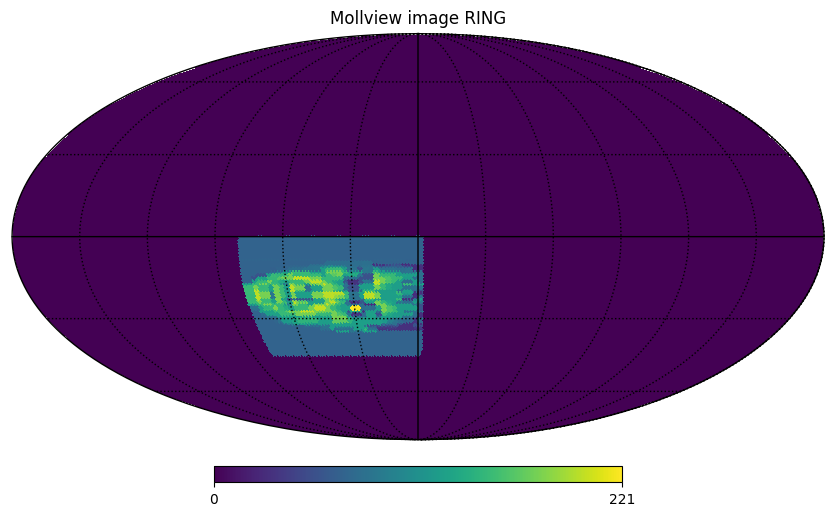

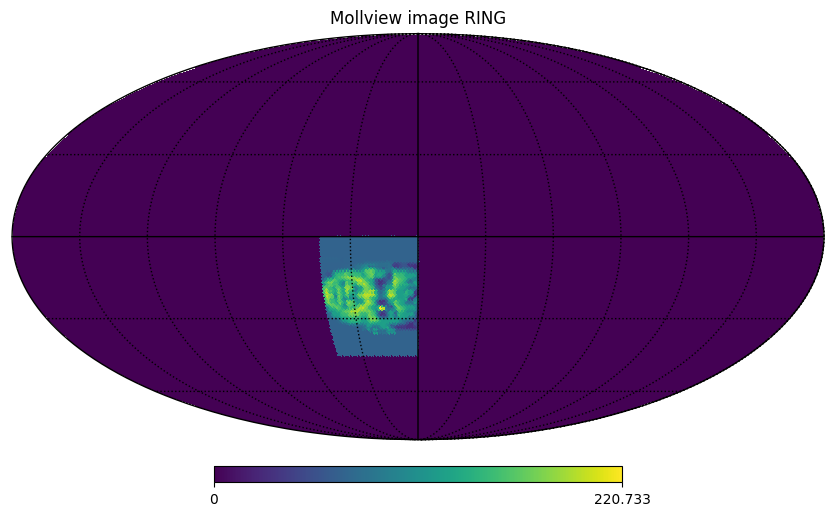

In [ ]:
img = cv2.imread("guy.jpg")
img = cv2.resize(img, (0,0), fx=0.1, fy=0.1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

print(img.shape)

height, width = img.shape

NSIDE = 64
NPIX = hp.nside2npix(NSIDE)

FOV = math.pi/4
OFFSET = [math.pi/2, 0]

m = np.zeros(NPIX)

angles = register_pixels(img, FOV, OFFSET)

sp = []

for angle in angles:
    res = find_overlapping_pixels(angle, FOV, width, height)
    m[res] = angle[2]
    sp.extend(res)

print(sp)

hp.mollview(m, title="Mollview image RING")
hp.graticule()

m2 = np.zeros(NPIX)

for p in sp:
    try:
        m2[p] = bilinear_interpolation(p, img, FOV, OFFSET)
        # print(m2[p])
    except Exception as e:
        print(e)
        continue

hp.mollview(m2, title="Mollview image RING")
hp.graticule()